In this notebook the result of scoring chosen haplotype path is presented. The path is obtained from the graph as the longest path. Then each daily haplotype is split into possible epitopes (of length 15 as it is a mean length of epitopes in train set of a model that is used for scoring). Epitopes are first converted into amino acid features with all possible hydrophobicity ratings, then scaled with the train set scaler and scored by the random forest classifier. It returnes the probability of immune response, meaning the probability shows if the daily haplotype is to cause the immune response at all. If the score is small it means the virus is successfully fidden from the immune system, otherwise the virus can be identified.

According to the plots there is no general tendency to become more human-like in all regions.

Will check region by region later.

In [1]:
%matplotlib inline
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# adding project folder to lib search path
project = os.path.split(os.getcwd())[0]
if project not in sys.path:
    sys.path.append(project)

from HIV_project.scripts.patient import Patient
from HIV_project.scripts.tree_building import Tree
from HIV_project.scripts.graph import Graph
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC, Gapped
from joblib import dump, load
from HIV_project.scripts.aa_properties import *
import warnings

warnings.filterwarnings('ignore')

In [2]:
# selecting patient
patient = Patient('p2')

No haplotype for patient p2 for region vpr
No haplotype for patient p2 for region p1
No haplotype for patient p2 for region p2
No haplotype for patient p2 for region p6
No haplotype for patient p2 for region p7


In [3]:
# loading classifier and scaler
clf = load('../HIV_immunogenicity/forest True False True False.joblib')
ss = load('../HIV_immunogenicity/ss True False True False.joblib')

In [4]:
# data preparation pipeline for current problem

def prepare_data(df):
    
    # adding amino acid & kidera scores (sum)
    df = df.merge(df.Epitope.apply(aaprop_sequence), right_index=True, left_index=True)
    
    # here we set columns which will remain in the dataset (either aa props or kidera factors)
    keep = ['alpha', 'charge', 'core', 'pH', 'polarity', 'rim', 'surface', 'turn', 'volume', 'count',
            'strength', 'disorder', 'mjenergy']
        
    # adding hydrophobicity score (sum)
    scales = ['Kyte-Doolittle', 'Hopp-Woods', 'Cornette', 'Eisenberg', 'Rose', 'Janin', 'Engelman GES']

    df = df.merge(df.Epitope.apply(lambda x: score_hydrophobicity_sequence(x, scales)), 
                  right_index=True, left_index=True)
    keep.extend(scales)

    return df[keep]

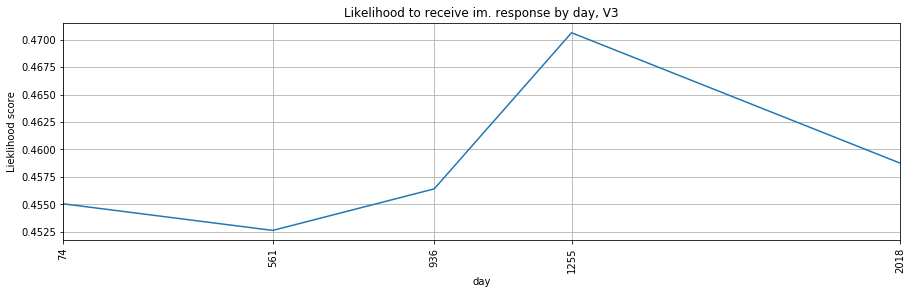

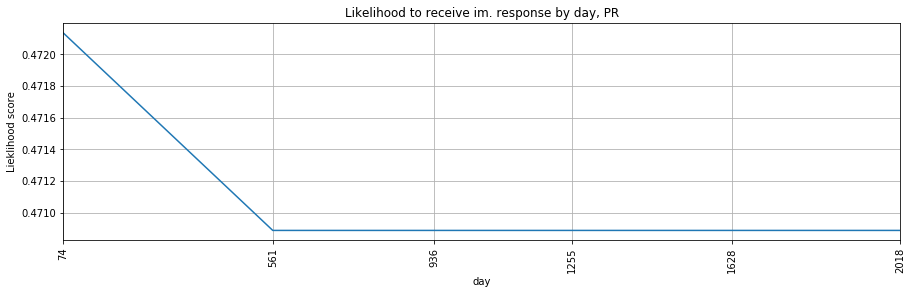

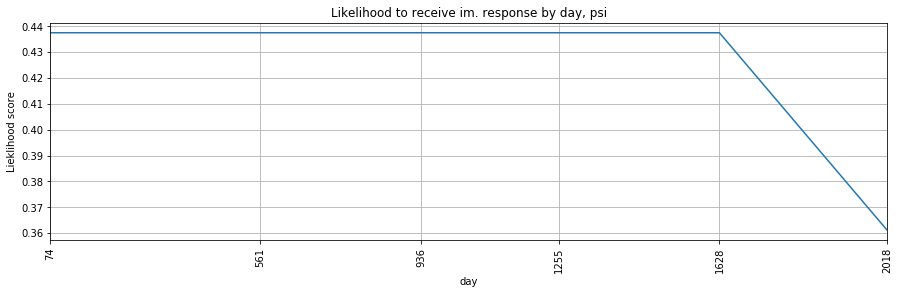

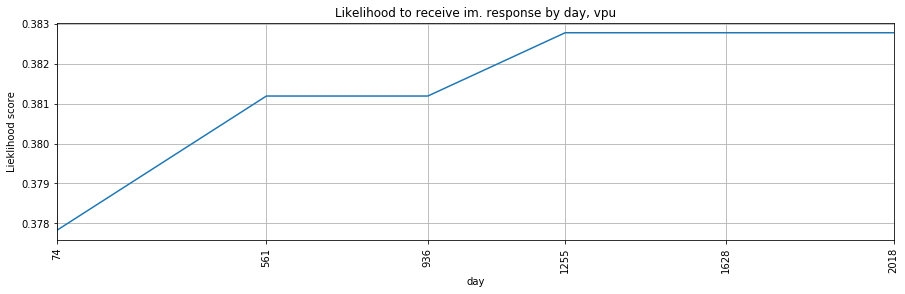

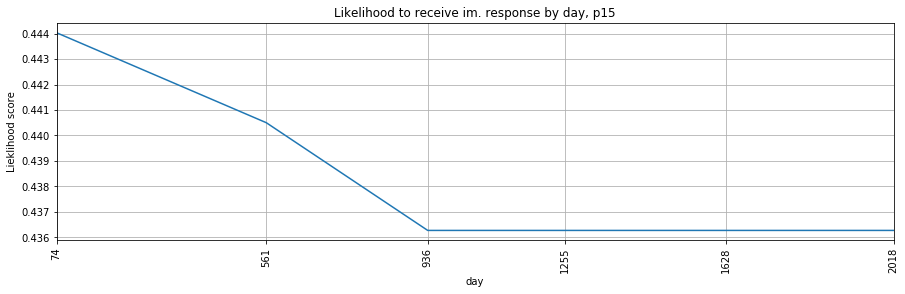

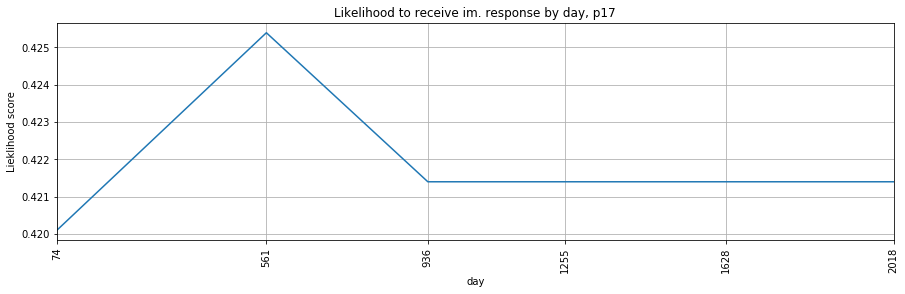

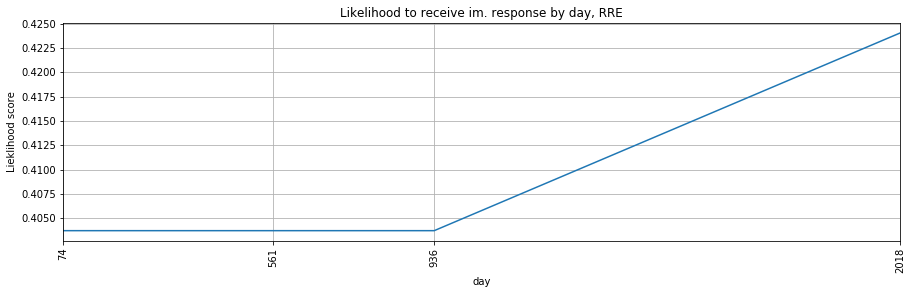

In [5]:
for region in patient.regions.keys:
    
    # building a tree for region
    tree = Tree(patient.regions[region])
    tree.build()
    
    # starting to plot the tree
    vertices = [i for i in range(len(tree.mapping))]
    edges = tree.graph

    # creating graph to get the longest path
    g = Graph()
    
    # adding vertices and edge weights
    g.add_vertices(vertices)
    g.set_edge_weights(edges)

    # calculating the longest path
    max_weight, max_path, edges = g.find_longest_path(tree)
    
    # making a dataset from vertex - seq mapping per day
    paths = pd.DataFrame.from_dict(data=tree.mapping, orient='index', columns=['mapping']).reset_index()
    paths[['day', 'seq']] = paths['index'].apply(pd.Series)
    paths.drop(['index', 'mapping'], axis=1, inplace=True)
    
    # selecting only seqs for days in the longest path
    target_paths = paths.iloc[max_path]
    tick_days = sorted(target_paths.day.unique())
    
    # translating to amino acids
    target_paths.loc[:, 'aa'] = target_paths.seq.apply(lambda x: Seq(x, 
                                                                     Gapped(IUPAC.unambiguous_dna)
                                                                    ).ungap().translate())
    
    # creating a dataframe of epitopes from seqs per day
    rows_list = []
    for row in target_paths.itertuples(index=False):
        day, _, aa = row
        epitope_lenght = 15
        epitopes = build_epitopes(aa, epitope_lenght)
        for epitope in epitopes:
            rows_list.append({'day': day, 'Epitope': epitope})
    epitope_df = pd.DataFrame(rows_list)
    
    epitope_df = epitope_df.drop_duplicates().sort_values(by=['day', 'Epitope']).reset_index(drop=True)
    
    # scaling data according to the train set
    data = ss.transform(prepare_data(epitope_df))
    
    # predicting probabilities for each epitope
    y_score = clf.predict_proba(data)[:, 1]
    
    epitope_df.loc[:, 'score'] = y_score
    
    # getting mean score for each day
    days = epitope_df.groupby('day').score.mean() 
    # days = days / days.max()

    # plotting scores per day
    plt.figure(figsize=(15, 4))
    days.plot() # ylim=(0, 1)
    plt.grid()
    plt.title(f'Likelihood to receive im. response by day, {region}')
    plt.ylabel('Lieklihood score')
    plt.xticks(tick_days, tick_days, rotation=90)
    plt.show()
